# Analyze the data to evaluate the relative performance of different gene weighting methods

Metrics:
1. Number of discoveries
2. Evaluate on contrast between silver standards

In [4]:
%load_ext lab_black

import pandas as pd
import itertools
import numpy as np
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [5]:
df_trait_info = pd.read_excel("../supp_tables.xlsx", sheet_name=0).set_index(
    "Trait_Identifier"
)

In [6]:
gwas_weight_list = (
    [f"top-{n}" for n in [100, 500, 1000, 2000]]
    + [f"fwer5-{n}" for n in [1000, 2000]]
    + [f"fdr1-{n}" for n in [1000, 2000]]
    + [f"fdr5-{n}" for n in [1000, 2000]]
)
gwas_weight_list = [
    f"{m}-{w}" for m, w in itertools.product(gwas_weight_list, ["zscore", "uniform"])
]
method_list = [
    f"{m}.{w}" for m, w in itertools.product(gwas_weight_list, ["uniform", "vs"])
]

In [7]:
subset_trait_list = [
    "PASS_Schizophrenia_Pardinas2018",
    "PASS_MDD_Howard2019",
    "PASS_AtrialFibrillation_Nielsen2018",
    "PASS_Rheumatoid_Arthritis",
    "UKB_460K.biochemistry_LDLdirect",
]

trait_list = df_trait_info.index.values

In [13]:
def summarize(method, trait_list):
    df_plot = {"method": [], "trait": [], "n_discovery": []}

    for trait in tqdm(trait_list):
        df_score = pd.read_csv(
            f"tms_facs/score_file/{method}/{trait}.score.gz", sep="\t", index_col=0
        )
        df_score["fdr"] = multipletests(df_score["pval"], method="fdr_bh")[1]
        df_plot["method"].append(method)
        df_plot["trait"].append(trait)
        df_plot["n_discovery"].append(np.sum(df_score["fdr"] < 0.1))
    return pd.DataFrame(df_plot)

In [14]:
import submitit

executor = submitit.AutoExecutor(folder="~/submitit/")
executor.update_parameters(timeout_min=10, mem_gb=12, slurm_partition="shared")

jobs = executor.map_array(
    lambda x: summarize(method=x, trait_list=trait_list),
    method_list,
)
df_plot = pd.concat(j.result() for j in jobs)
df_plot.to_csv("power_summary.csv", index=False)

In [24]:
df_plot = pd.read_csv("power_summary.csv")

df_plot["gwas_weight"] = df_plot["method"].apply(lambda x: x.split(".")[0])
df_plot["sc_weight"] = df_plot["method"].apply(lambda x: x.split(".")[1])

# sc_weight: vs > uniform
This is consistently across traits

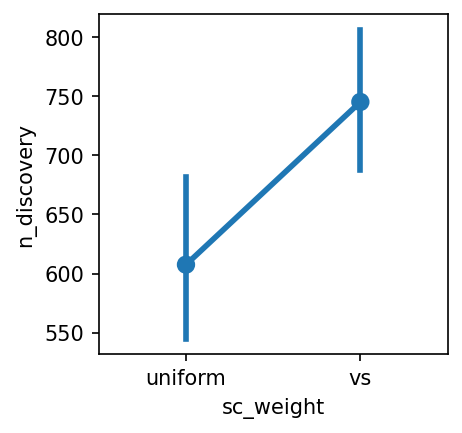

In [25]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
sns.pointplot(data=df_plot, x="sc_weight", y="n_discovery")
plt.show()

Therefore, we consistently use "vs" weighting for now

In [26]:
df_plot = df_plot[df_plot.sc_weight == "vs"].drop(columns=["sc_weight"])

# Thresholding with FWER is not ideal

In [30]:
# trait-specific maximum
dict_trait_max = (
    df_plot.groupby("trait").apply(lambda x: np.max(x["n_discovery"])).to_dict()
)
df_plot["normalized_n_discovery"] = df_plot.apply(
    lambda x: x["n_discovery"] / dict_trait_max[x.trait], axis=1
)
df_plot = df_plot[
    df_plot.trait.isin([trait for trait, n in dict_trait_max.items() if n > 50])
]
df_plot_avg = df_plot.groupby("gwas_weight").mean().loc[gwas_weight_list]
display(df_plot.groupby("gwas_weight").mean().loc[gwas_weight_list])

,n_discovery,normalized_n_discovery
gwas_weight,,
top-100-zscore,78.594203,0.050126
top-100-uniform,77.434783,0.046899
top-500-zscore,548.144928,0.294260
top-500-uniform,498.260870,0.252404
top-1000-zscore,1015.275362,0.563915
top-1000-uniform,879.391304,0.501161
top-2000-zscore,1547.826087,0.910302
top-2000-uniform,1208.565217,0.678579
fwer5-1000-zscore,583.521739,0.277130


In [34]:
from scipy.stats import pearsonr, spearmanr
df_plot = {"method": [], "trait": [], "n_discovery": []}

for trait in trait_list:
    # for trait in df_trait_info.index:
    dict_df_score = {}
    for w in ["top-1000-uniform", "top-1000-zscore"]:
        df_score = pd.read_csv(
            f"tms_facs/score_file/{w}.vs/{trait}.score.gz",
            sep="\t",
            index_col=0,
        )
        df_score["fdr"] = multipletests(df_score["pval"], method="fdr_bh")[1]
        dict_df_score[w] = df_score
    print(
        trait,
        pearsonr(dict_df_score["top-1000-uniform"].zscore, dict_df_score["top-1000-zscore"].zscore)[0],
    )

PASS_CD_deLange2017 0.9681643397631314
PASS_Celiac 0.9631104358267792
PASS_IBD_deLange2017 0.970175398859339
PASS_Lupus 0.9655275301477497
PASS_Multiple_sclerosis 0.9776326178985083
PASS_Primary_biliary_cirrhosis 0.972340949734542
PASS_Rheumatoid_Arthritis 0.975524836764889
PASS_UC_deLange2017 0.9654322787856948
UKB_460K.blood_EOSINOPHIL_COUNT 0.9962354554582359


KeyboardInterrupt: 